<h1>4. Zeitreihen vorhersagen (Statistik II): ARIMA-Modelle</h1>
<h4>Session 4 (Donnerstag 15:15 - 17:00)</h4>
<br>
4.1 Autoregressive- (AR) und Moving Average (MA) Modelle<br>
4.2 Mit ARMA und ARIMA-Modellen vorhersagen<br>
4.3 Mit SARIMA-Modellen Saisonalität berücksichtigen<br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
em = pd.read_csv("em_HH8_2012_05.csv", index_col=0)
em['Zeit'] = pd.to_datetime(em['Zeit'])
em.set_index('Zeit', inplace=True)
em.index.freq = 'H'
em.head()

,Strom
Zeit,
2012-05-01 00:00:00,834.0
2012-05-01 01:00:00,824.0
2012-05-01 02:00:00,681.0
2012-05-01 03:00:00,530.0
2012-05-01 04:00:00,672.0


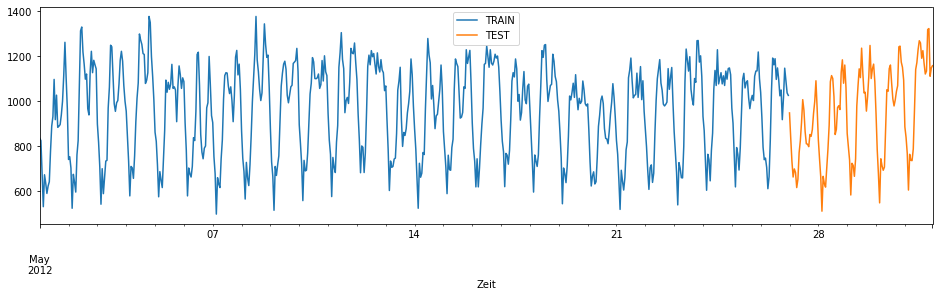

In [4]:
train_em = em[:624]
test_em = em[624:]
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4));

<h3> Ein-Schrittvorhersage Naiv </h3>

In [39]:
train_em.tail()

,Strom
Zeit,
2012-05-26 19:00:00,1016.0
2012-05-26 20:00:00,1146.0
2012-05-26 21:00:00,1092.0
2012-05-26 22:00:00,1036.0
2012-05-26 23:00:00,1025.0


In [41]:
naiv = pd.DataFrame()
naiv = naiv.reindex_like(test_em)
#naiv = naiv.assign('Strom'==last)
naiv['Strom'] = train_em.iloc[623]['Strom']
naiv.columns = ['Naive Vorhersage']
naiv.head()

,Naive Vorhersage
Zeit,
2012-05-27 00:00:00,1025.0
2012-05-27 01:00:00,1025.0
2012-05-27 02:00:00,1025.0
2012-05-27 03:00:00,1025.0
2012-05-27 04:00:00,1025.0


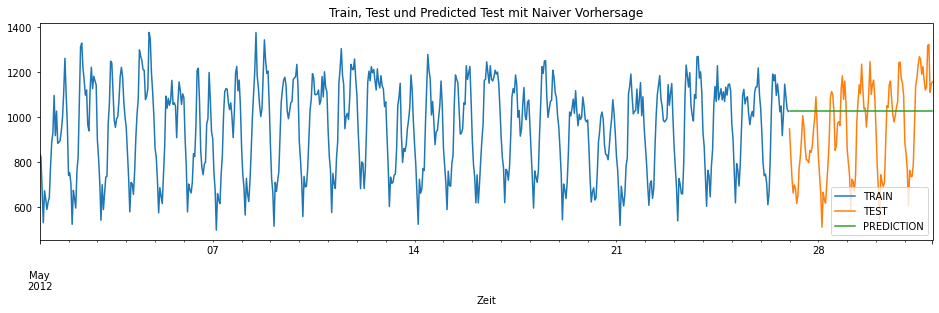

In [54]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
naiv['Naive Vorhersage'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit Naiver Vorhersage');

<h3> ARIMA-Modelle: Zuerst Voraussetzungen prüfen </h3>

Ist die Zeitreihe stationär?<br>
Dickey-Fuller-Test (Null-Hypothese nicht stationär)

In [50]:
testresults = adfuller(em)
print("Test statistic = {:.2f}".format(testresults[0]))
print("p-Value = {:.2f}".format(testresults[1]))
print("Number of lags = {:.2f}".format(testresults[2]))
print("Number of observations = {:.2f}".format(testresults[3]))
print("Critical value at 1% = {:.2f}".format(testresults[4]["1%"]))
print("Critical value at 5% = {:.2f}".format(testresults[4]["5%"]))
print("Critical value at 10% = {:.2f}".format(testresults[4]["10%"]))

Test statistic = -3.63
p-Value = 0.01
Number of lags = 20.00
Number of observations = 723.00
Critical value at 1% = -3.44
Critical value at 5% = -2.87
Critical value at 10% = -2.57


<h3> ARIMA-Modelle: Zuerst p,d,q, P,D,Q, s bestimmen </h3>

<h3>Geometrische Hinweise aus der ACF- und PACF-Funktion</h3>

Die ACF- und PACF-Kurven sollten zusammen betrachtet werden, um den Prozess zu definieren. Bei einem AR-Prozess erwarten wir, dass die ACF-Kurve allmählich abnimmt und gleichzeitig die PACF-Kurve nach p signifikanten Verzögerungen einen starken Abfall aufweist. Um einen MA-Prozess zu definieren, erwarten wir von den ACF- und PACF-Diagrammen das Gegenteil, d. h., die ACF sollte nach einer bestimmten Anzahl q von Lags einen starken Abfall aufweisen, während die PACF einen geometrischen oder allmählich abnehmenden Trend zeigen sollte. Zeigen dagegen sowohl die ACF- als auch die PACF-Kurven ein allmählich abnehmendes Muster, dann sollte der ARMA-Prozess für die Modellierung in Betracht gezogen werden.

Wir können die Ordnung p für das AR(p)-Modell auf der Grundlage signifikanter Spikes aus dem PACF-Diagramm auswählen. Alles, was außerhalb der blauen Begrenzung des PACF-Diagramms liegt, gibt Hinweise auf die Ordnung des AR-Modells.

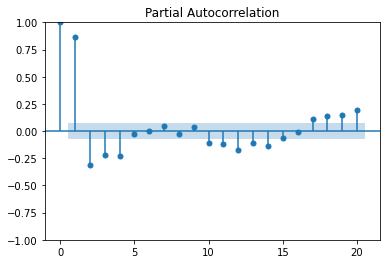

In [57]:
plot_pacf(em, lags=20, method='ywm');

In [58]:
for_mod = SARIMAX(train_em, 
              order=(4, 0, 0))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1948      0.041     28.816      0.000       1.114       1.276
ar.L2         -0.1083      0.071     -1.520      0.128      -0.248       0.031
ar.L3         -0.0703      0.070     -1.009      0.313      -0.207       0.066
ar.L4         -0.0234      0.045     -0.524      0.600      -0.111       0.064
sigma2      1.006e+04    676.757     14.867      0.000    8735.235    1.14e+04


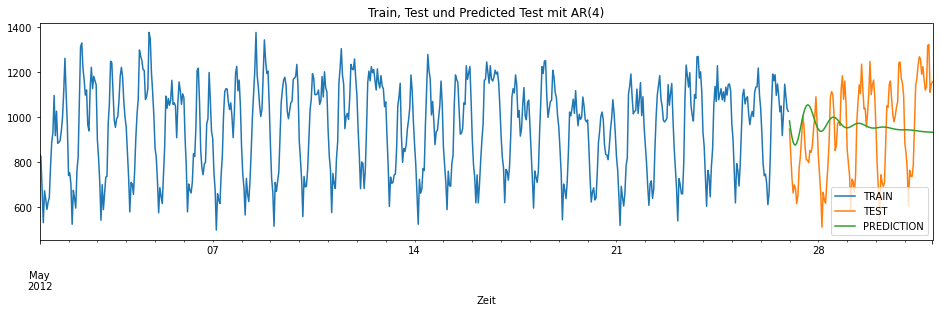

In [67]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit AR(4)');

Im Gegensatz zum AR-Modell kann die Ordnung q für das Modell MA(q) aus dem ACF ausgewählt werden, wenn dieses Diagramm einen scharfen Cut-off nach dem Lag q aufweist.

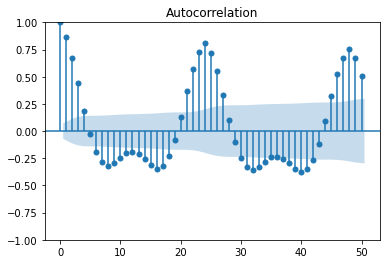

In [69]:
plot_acf(em, lags=50);

In [64]:
warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(4, 0, 3))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0003      0.111     17.959      0.000       1.782       2.219
ar.L2         -0.3988      0.314     -1.270      0.204      -1.014       0.217
ar.L3         -1.3556      0.308     -4.407      0.000      -1.959      -0.753
ar.L4          0.7541      0.105      7.202      0.000       0.549       0.959
ma.L1         -0.9995      0.097    -10.351      0.000      -1.189      -0.810
ma.L2         -0.7723      0.171     -4.511      0.000      -1.108      -0.437
ma.L3          0.7950      0.083      9.619      0.000       0.633       0.957
sigma2      8473.8607    543.588     15.589      0.000    7408.447    9539.274


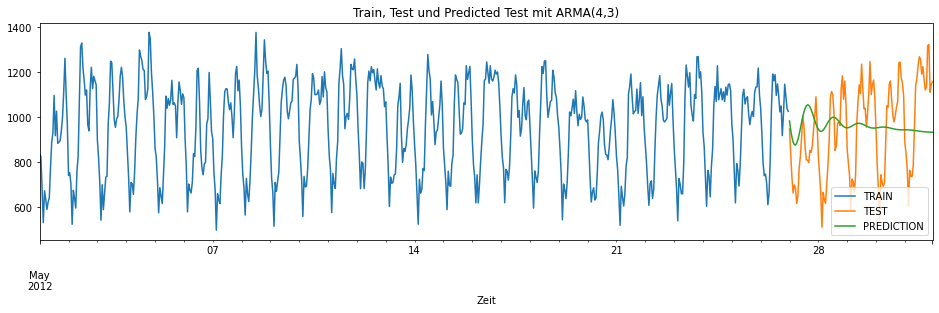

In [68]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit ARMA(4,3)');

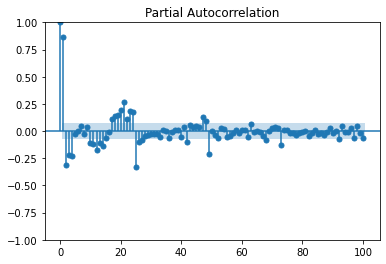

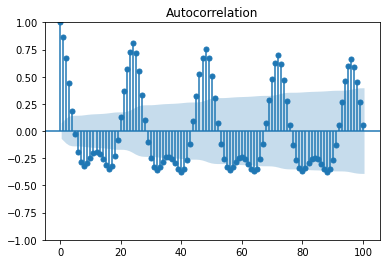

In [70]:
plot_pacf(em, lags=100, method='ywm');plot_acf(em, lags=100);

In [72]:
#warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(4, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0825      0.035     30.971      0.000       1.014       1.151
ar.L2          0.6632      0.030     22.224      0.000       0.605       0.722
ar.L3         -1.0662      0.039    -27.630      0.000      -1.142      -0.991
ar.L4          0.3204      0.011     28.269      0.000       0.298       0.343
ma.L1         -0.3837      0.052     -7.354      0.000      -0.486      -0.281
ma.L2         -0.9182      0.053    -17.251      0.000      -1.022      -0.814
ma.L3          0.3055      0.036      8.397      0.000       0.234       0.377
ar.S.L24       0.9974      0.002    403.334      0.000       0.993       1.002
ma.S.L24      -0.9185      0.037    -25.128      0.000      -0.990      -0.847
sigma2      7391.2489   2.22e-06   3.33e+09      0.000    7391.249    7391.249


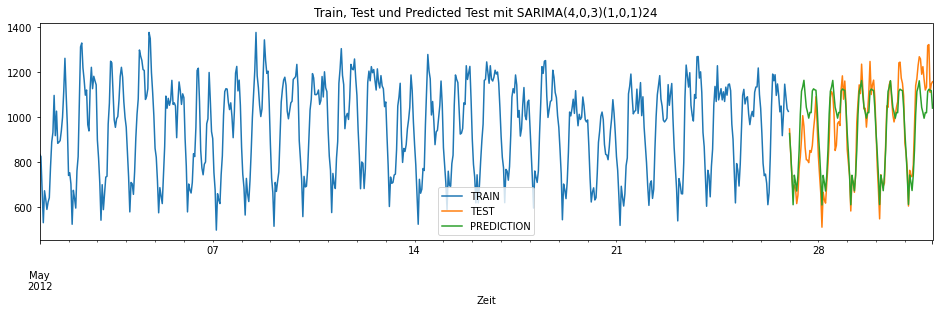

In [73]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(4,0,3)(1,0,1)24');

Zur Validierung des Modells z.B. prüfen, ob die Residuen, also die geschätzten $\epsilon_t$, unkorreliert sind und sich wie weißes Rauschen verhalten.

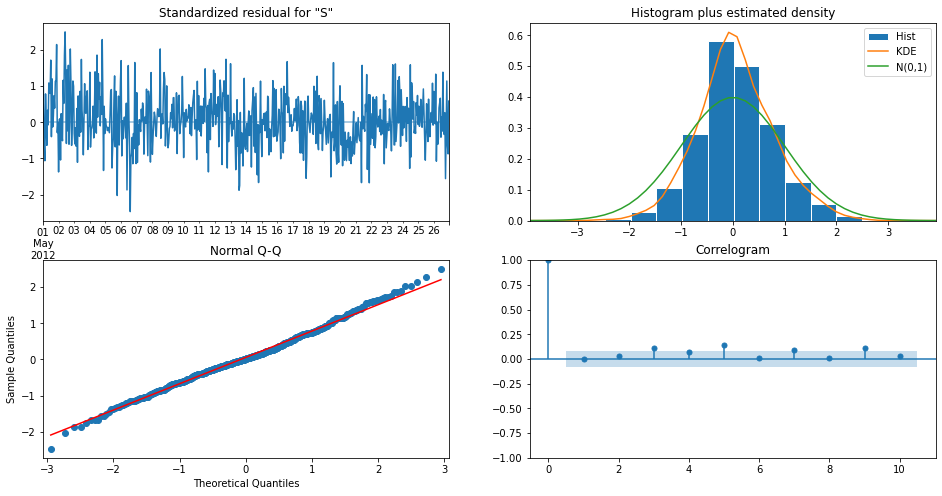

In [78]:
for_results.plot_diagnostics(figsize=(16, 8))
plt.show()

<h3>Wie gut ist mein Modell?</h3>

Erinnerung:<br>
Mean Absolute Error Holt-Winter = 385.86<br>
Mean Squared Error Holt-Winter = 226554.12

In [74]:
y_tru = test_em
y_SARIMA = for_pred.predicted_mean
errors = [['Mean Absolute Error', 385.86, mean_absolute_error(y_tru,y_SARIMA)], ['Mean Squared Error', 226554.12, mean_squared_error(y_tru,y_SARIMA)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Holt-Winters Vorhersage','SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 

,Holt-Winters Vorhersage,SARIMA Vorhersage
Art des Fehlers,,
Mean Absolute Error,385.86,72.76
Mean Squared Error,226554.12,9301.18


<h3> Modellidentifikation: (p,d,q)(P,D,Q) bestimmen </h3>
Man kann die Parameter noch systematischer bestimmen - bzw. bestimmen lassen

In [75]:
# -> dauert evtl lange (ca. 1-2 Min)...
warnings.filterwarnings("ignore")
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
print(pdq)
print(seasonal_pdq)
df = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(train_em,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        d = {
            'non-seasonal' : param,
            'seasonal' : param_seasonal,
            'AIC' : results.aic
        }
        df.append(d)
df = pd.DataFrame(df)
df['AIC'] = df['AIC'].astype(float)
df.to_csv('pdqPDQ.csv') 

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 24), (0, 0, 1, 24), (0, 1, 0, 24), (0, 1, 1, 24), (1, 0, 0, 24), (1, 0, 1, 24), (1, 1, 0, 24), (1, 1, 1, 24)]


In [76]:
pdq = pd.read_csv("pdqPDQ.csv")
pdq = pdq.drop(columns=['Unnamed: 0'])
print('Beispiele...')
print(pdq.head())
print('Minimum AIC bei')
print(pdq[ pdq['AIC'] == pdq['AIC'].min() ])

Beispiele...
  non-seasonal       seasonal           AIC
0    (0, 0, 0)  (0, 0, 0, 24)  10346.855376
1    (0, 0, 0)  (0, 0, 1, 24)   9272.280211
2    (0, 0, 0)  (0, 1, 0, 24)   7343.981010
3    (0, 0, 0)  (0, 1, 1, 24)   6719.442983
4    (0, 0, 0)  (1, 0, 0, 24)   7357.678058
Minimum AIC bei
   non-seasonal       seasonal          AIC
63    (1, 1, 1)  (1, 1, 1, 24)  6329.567416


<div class="alert alert-info">
- Führe mit dem vorgeschlagenen Modell eine SARIMA-Vorhersage für unsere Testzeitspanne durch<br>
- Plotte die Ergebnisse deiner Vorhersage in den obigen Plot dazu (so, dass du auch die SARIMA-Ergebnisse mit händisch bestimmten Parametern im selben Plot hast)<br>
- Passe die Labels an, so dass klar wird welche Linie was ist<br>
- Wie sieht es aus? Kann man einen Unterschied erkennen?<br>
- Bestimme zu deiner Analyse die Fehlermaße und füge sie in die obige Tabelle ein<br>
- Welche SARIMA-Analyse schneidet besser ab? Warum denkst du ist das so?
</div>